🚀 Fetching BTC_USDT price history...
⏳ Fetching DVOL history from Deribit...


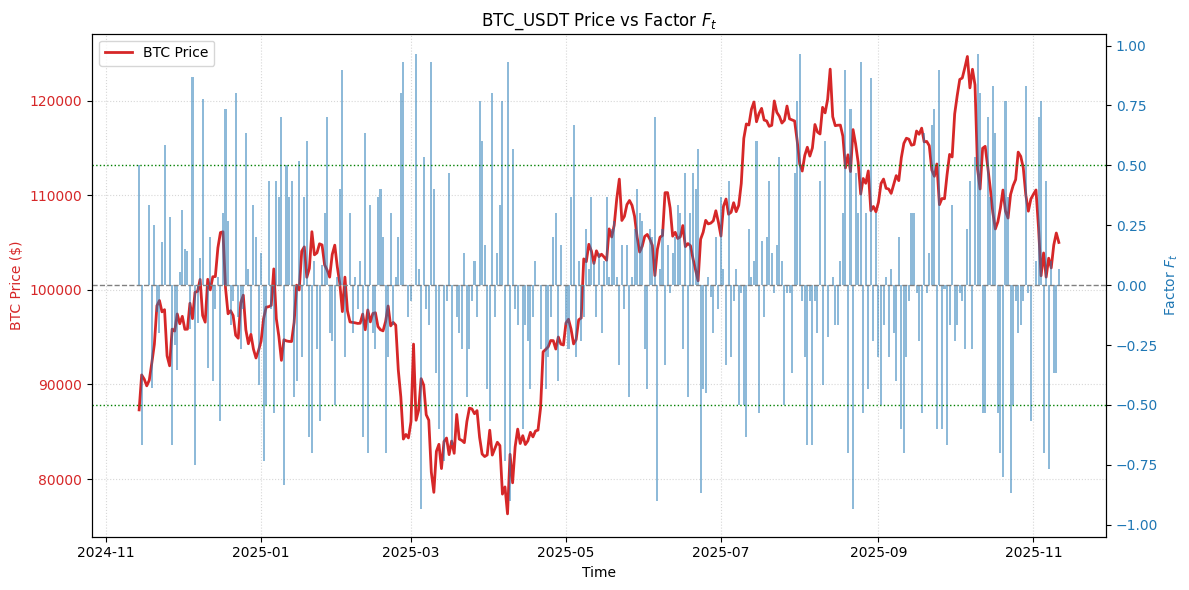

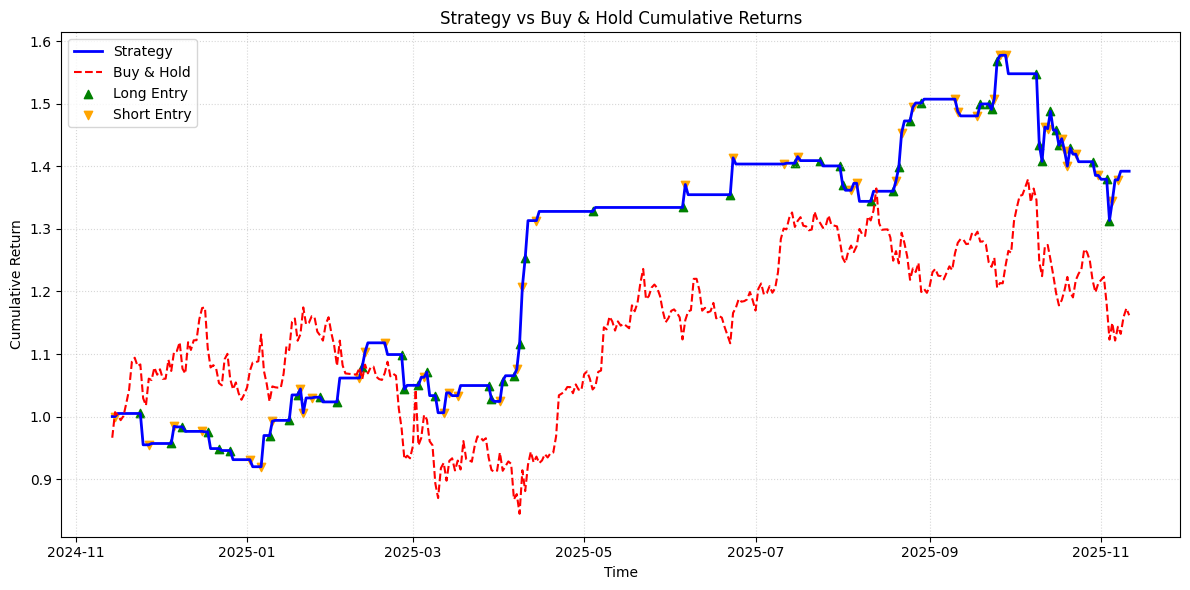


--- Backtest Summary ---
Total periods: 363
Strategy final cumulative return: 1.39x
Buy & Hold cumulative return: 1.16x
------------------------------
Last 5 signals:
               Price  DVOL_Close         F  signal  strategy_cumulative
time                                                                   
2025-11-07  103341.2       44.61 -0.766667    -1.0             1.378380
2025-11-08  102316.2       44.88  0.100000     0.0             1.392188
2025-11-09  104731.1       45.11 -0.366667     0.0             1.392188
2025-11-10  106002.9       44.30 -0.366667     0.0             1.392188
2025-11-11  105005.0       44.36  0.066667     0.0             1.392188


In [33]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Configurations ---
GATEIO_HOST = "https://api.gateio.ws"
DERIBIT_HOST = "https://www.deribit.com/api/v2/public"  # Deribit Public API
GATEIO_PREFIX = "/api/v4"

# -----------------------------
# 1. Fetch Spot K-Line History Close Prices (Gate.io)
# -----------------------------
def fetch_price_history(symbol, interval, limit): 
    url = f"{GATEIO_HOST}{GATEIO_PREFIX}/spot/candlesticks"
    params = {
        "currency_pair": symbol,
        "interval": interval, 
        "limit": limit
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()
    
    df = pd.DataFrame(data, columns=['time', 'volume', 'close', 'high', 'open', 'low', 'quote_volume', 'count'])
    df['time'] = pd.to_datetime(df['time'].astype(int), unit='s')
    df['close'] = df['close'].astype(float)
    df = df.sort_values('time').reset_index(drop=True)
    
    return df[['time', 'close']].rename(columns={'close': 'Price'})

# -----------------------------
# 2. Fetch DVOL Historical Data (Deribit)
# -----------------------------
def fetch_dvol_history(start_time_ms, end_time_ms, index_name="BTC_DVOL", resolution=86400, currency="BTC"): 
    url = f"{DERIBIT_HOST}/get_volatility_index_data"
    params = {
        "index_name": index_name,
        "start_timestamp": start_time_ms,
        "end_timestamp": end_time_ms,
        "resolution": resolution,
        "currency": currency 
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status() 
    data = resp.json()
    
    if data['result'] is None or 'data' not in data['result']:
        raise ValueError("DVOL data not found or API response error.")
        
    dvol_data = data['result']['data']
    df = pd.DataFrame(dvol_data, columns=['time_ms', 'open', 'high', 'low', 'DVOL_Close'])
    df['time'] = pd.to_datetime(df['time_ms'], unit='ms')
    df['DVOL_Close'] = df['DVOL_Close'].astype(float)
    
    return df[['time', 'DVOL_Close']].sort_values('time')

# -----------------------------
# Main Program
# -----------------------------
def main():
    SYMBOL = "BTC_USDT"
    PRICE_INTERVAL = "1d"
    DVOL_RESOLUTION = 86400
    LIMIT = 365
    LONG_THRESHOLD = 0.5
    SHORT_THRESHOLD = -0.5
    WINDOW_SIZE = 30  # 歷史窗口大小，用於滾動百分位計算
    
    print(f"🚀 Fetching {SYMBOL} price history...")
    try:
        df_price = fetch_price_history(SYMBOL, interval=PRICE_INTERVAL, limit=LIMIT)
    except Exception as e:
        print(f"🔴 Failed to fetch price history: {e}")
        return

    end_time = df_price['time'].max()
    start_time = df_price['time'].min()
    end_time_ms = int(end_time.timestamp() * 1000)
    start_time_ms = int((start_time - timedelta(days=2)).timestamp() * 1000)

    print("⏳ Fetching DVOL history from Deribit...")
    try:
        df_dvol = fetch_dvol_history(start_time_ms, end_time_ms, resolution=DVOL_RESOLUTION)
    except Exception as e:
        print(f"🔴 Failed to fetch DVOL history: {e}")
        return

    # --- Data Alignment ---
    df_aligned = pd.merge_asof(left=df_price, right=df_dvol, on='time', direction='nearest')
    df_aligned = df_aligned.dropna(subset=['DVOL_Close']).set_index('time')

    if len(df_aligned) < 2:
        print("🔴 Not enough data points.")
        return

    # --- Calculate Returns ---
    df_factor = df_aligned.copy()
    df_factor['rtP'] = np.log(df_factor['Price']).diff()
    df_factor['rtT'] = df_factor['DVOL_Close'].diff()
    df_factor = df_factor.dropna(subset=['rtP', 'rtT'])

    # --- Rolling Rank Percentile (No Look-Ahead) ---
    def rolling_rank_pct(x):
        return pd.Series(x).rank(pct=True).iloc[-1]

    df_factor['uP'] = df_factor['rtP'].rolling(WINDOW_SIZE, min_periods=1).apply(rolling_rank_pct, raw=False)
    df_factor['uT'] = df_factor['rtT'].rolling(WINDOW_SIZE, min_periods=1).apply(rolling_rank_pct, raw=False)
    df_factor['F'] = df_factor['uT'] - df_factor['uP']

    # --- Generate Signals ---
    df_factor['signal'] = 0.0
    df_factor.loc[df_factor['F'] > LONG_THRESHOLD, 'signal'] = 1.0
    df_factor.loc[df_factor['F'] < SHORT_THRESHOLD, 'signal'] = -1.0

    # --- Backtest ---
    df_factor['strategy_return'] = df_factor['signal'].shift(1) * df_factor['rtP']
    df_factor = df_factor.dropna(subset=['strategy_return'])
    df_factor['benchmark_return'] = df_factor['rtP']
    df_factor['strategy_cumulative'] = np.exp(df_factor['strategy_return'].cumsum())
    df_factor['benchmark_cumulative'] = np.exp(df_factor['benchmark_return'].cumsum())

    # --- Plot Factor vs Price ---
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('BTC Price ($)', color=color)
    ax1.plot(df_factor.index, df_factor['Price'], color=color, linewidth=2, label='BTC Price')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle=':', alpha=0.5)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Factor $F_t$', color=color)
    time_diffs = df_factor.index.to_series().diff().dropna()
    bar_width = time_diffs.min() * 0.8 if len(time_diffs) > 0 else timedelta(hours=20)
    ax2.bar(df_factor.index, df_factor['F'], color=color, alpha=0.5, width=bar_width)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax2.axhline(LONG_THRESHOLD, color='green', linestyle=':', linewidth=1)
    ax2.axhline(SHORT_THRESHOLD, color='green', linestyle=':', linewidth=1)
    ax2.set_ylim(-1.05, 1.05)
    ax2.tick_params(axis='y', labelcolor=color)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.title(f"{SYMBOL} Price vs Factor $F_t$")
    plt.tight_layout()
    plt.show()

    # --- Plot Cumulative Returns ---
    fig2, ax3 = plt.subplots(figsize=(12, 6))
    ax3.plot(df_factor.index, df_factor['strategy_cumulative'], label='Strategy', color='blue', linewidth=2)
    ax3.plot(df_factor.index, df_factor['benchmark_cumulative'], label='Buy & Hold', color='red', linestyle='--')
    long_entries = df_factor[df_factor['signal'] == 1.0]
    short_entries = df_factor[df_factor['signal'] == -1.0]
    ax3.scatter(long_entries.index, long_entries['strategy_cumulative'], marker='^', color='green', label='Long Entry')
    ax3.scatter(short_entries.index, short_entries['strategy_cumulative'], marker='v', color='orange', label='Short Entry')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Cumulative Return')
    ax3.grid(True, linestyle=':', alpha=0.5)
    ax3.legend(loc='upper left')
    plt.title(f"Strategy vs Buy & Hold Cumulative Returns")
    plt.tight_layout()
    plt.show()

    # --- Metrics ---
    print("\n--- Backtest Summary ---")
    print(f"Total periods: {len(df_factor)}")
    print(f"Strategy final cumulative return: {df_factor['strategy_cumulative'].iloc[-1]:.2f}x")
    print(f"Buy & Hold cumulative return: {df_factor['benchmark_cumulative'].iloc[-1]:.2f}x")
    print("-" * 30)
    print("Last 5 signals:")
    print(df_factor[['Price', 'DVOL_Close', 'F', 'signal', 'strategy_cumulative']].tail(5))

if __name__ == "__main__":
    main()
